# Preservation potential maps

This notebook creates animations showing the cumulative erosion and preservation potential maps created in notebook `05`.

If training data has been extracted from the source datasets by running the `00c-extract_training_data_global.ipynb` and `00b-extract_grid_data.ipynb` notebooks, set the `use_extracted_data` variable below to `True` to use this dataset instead of the pre-prepared training data from the [Zenodo repository](https://zenodo.org/record/8157691).

## Notebook options

These cells set some of the important variables and definitions used throughout the notebook.

### Select plate model

To use the plate model from the published paper (Alfonso et al., 2024), set `use_provided_plate_model` to `True`. Otherwise, leave `use_provided_plate_model` as `False` and set `plate_model_name` to a valid model name for the [`plate-model-manager`](https://github.com/michaelchin/plate-model-manager/blob/4f66423b53950bf42f5dac1228e61fd1e19fdf6e/models.json) package, or set `plate_model_name` to `None` and place GPlates files in a directory named `plate_model`.

| `use_provided_plate_model` | `plate_model_name` | result |
| - | - | - |
| `True` | Any | Use Alfonso et al., 2024 model |
| `False` | Model name string (e.g. `"muller2022"`) | Use specified plate model |
| `False` | `None` | Use files in `plate_model` directory |

In [ ]:
use_provided_plate_model = True
plate_model_name = "muller2022"

### Set other parameters

In [ ]:
# If True, use training data extracted in notebook 00c
# Else, use pre-prepared training data downloaded from Zenodo
use_extracted_data = True

# Number of processes to use
n_jobs = 4

# Control verbosity level of logging output
verbose = False

These values will usually not need to be modified:

In [ ]:
import os

from lib.check_files import check_prepared_data

if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = check_prepared_data("prepared_data")

outputs_dir = "outputs"
filename_template = r"image_{:0.0f}Ma.png"

erorate_dir = os.path.join("source_data", "ErosionDeposition")

If any of the following exist as environment variables, they will replace the values defined above:

In [ ]:
n_jobs = int(os.environ.get("N_JOBS", n_jobs))
verbose = bool(int(os.environ.get("VERBOSE", verbose)))

## Notebook setup

Imports, definitions, etc.

### Imports

In [2]:
import re
import tempfile

import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from gplately import PlotTopologies
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
)

from lib.animation import create_animation
from lib.check_files import (
    check_plate_model,
)
from lib.erodep import (
    plot_combined,
    plot_combined_maps,
    plot_erosion,
    plot_erosion_maps,
    plot_erosion_rate,
    plot_erosion_rate_maps,
    plot_likelihood,
    plot_likelihood_maps,
)
from lib.plate_models import (
    get_plate_reconstruction,
    get_plot_topologies,
)

NOTEBOOK = "get_ipython" in dir()

### Input and output files

In [4]:
# Input
input_filename = os.path.join(
    data_dir,
    "grid_data.csv",
)
deposits_filename = os.path.join(
    data_dir,
    "training_data_global.csv",
)
erosion_grids_dir = os.path.join(outputs_dir, "erosion_grids")
outputs_dir = os.path.join(outputs_dir, "global")

# Determine time steps
filenames = [
    i for i in os.listdir(erosion_grids_dir)
    if i.endswith(".nc")
]
pattern = re.compile(r"[0-9]+Ma")
times = sorted([
    int(pattern.findall(f)[0].replace("Ma", ""))
    for f in filenames
])

# Output
likelihood_dir = os.path.join(
    outputs_dir,
    "preservation_likelihood_grids",
)
prospectivity_dir = os.path.join(
    outputs_dir,
    "PU",
    "probability_grids",
)
output_filename_erosion = os.path.join(
    outputs_dir,
    "erosion.mp4",
)
output_filename_rate = os.path.join(
    outputs_dir,
    "erosion_rate.mp4",
)
output_filename_likelihood = os.path.join(
    outputs_dir,
    "likelihood.mp4",
)
output_filename_combined = os.path.join(
    outputs_dir,
    "PU",
    "prospectivity_likelihood.mp4",
)
output_filename_combined_nodeps = os.path.join(
    os.path.dirname(output_filename_combined),
    os.path.basename(output_filename_combined).replace(".mp4", "_nodeps.mp4"),
)

Plate model files:

In [ ]:
plate_model_dir = "plate_model"
if use_provided_plate_model:
    check_plate_model(plate_model_dir, verbose=True)
    plate_model_name = None
plate_model, _tf = get_plate_reconstruction(
    model_name=plate_model_name,
    model_dir=plate_model_dir,
    filter_topologies=True,
)

if use_provided_plate_model:
    coastlines_filenames = [os.path.join(
        plate_model_dir,
        "StaticGeometries",
        "AgeGridInput",
        "CombinedTerranes.gpml",
    )]
    gplot = PlotTopologies(
        plate_model,
        coastlines=coastlines_filenames,
    )
else:
    gplot = get_plot_topologies(
        model_name=plate_model_name,
        model_dir=plate_model_dir,
        plate_reconstruction=plate_model,
        filter_topologies=True,
    )

projection = ccrs.Mollweide()

## Create animations

### Erosion rate

#### Example plot

Create an example plot at a single time step (by default, 135 Ma).

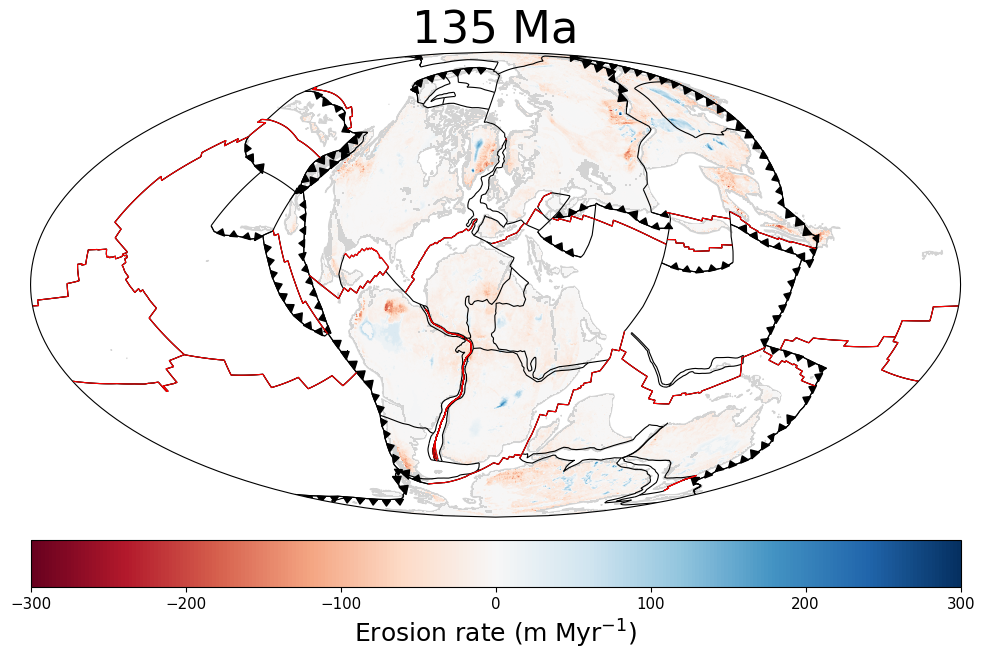

In [6]:
if NOTEBOOK:
    time = 135
    _ = plot_erosion_rate(
        time=time,
        gplot=gplot,
        input_dir=erorate_dir,
        projection=projection,
        output_filename=None,
    )

#### All plots

In [7]:
with tempfile.TemporaryDirectory() as tmpdir:
    plot_erosion_rate_maps(
        times=times,
        gplot=gplot,
        input_dir=erorate_dir,
        output_dir=tmpdir,
        projection=projection,
        n_jobs=n_jobs,
        verbose=verbose,
        output_template=filename_template,
    )
    image_filenames = [
        os.path.join(
            tmpdir,
            filename_template.format(t),
        )
        for t in sorted(times, reverse=True)
    ]
    create_animation(
        image_filenames=image_filenames,
        output_filename=output_filename_rate,
        fps=5,
        logger=None,
        threads=n_jobs,
    )

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  7.1min remaining: 21.2min


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  7.4min finished


### Cumulative erosion

#### Example plot

Create an example plot at a single time step (by default, 135 Ma).

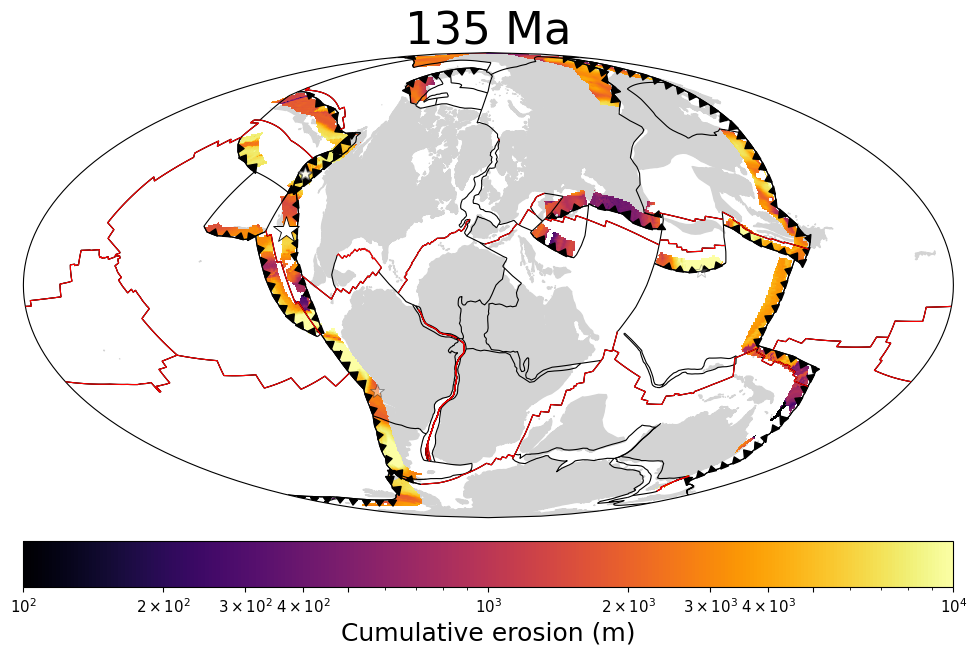

In [8]:
time = 135
_ = plot_erosion(
    time=time,
    gplot=gplot,
    input_dir=erosion_grids_dir,
    projection=projection,
    output_filename=None,
    deposits=deposits_filename,
)


#### All plots

In [9]:
with tempfile.TemporaryDirectory() as tmpdir:
    plot_erosion_maps(
        times=times,
        gplot=gplot,
        input_dir=erosion_grids_dir,
        output_dir=tmpdir,
        projection=projection,
        n_jobs=n_jobs,
        verbose=10 * int(verbose),
        output_template=filename_template,
        deposits=deposits_filename,
    )
    image_filenames = [
        os.path.join(
            tmpdir,
            filename_template.format(t),
        )
        for t in sorted(times, reverse=True)
    ]
    create_animation(
        image_filenames=image_filenames,
        output_filename=output_filename_erosion,
        fps=5,
        logger=None,
        threads=n_jobs,
    )

Loading data from file: /Users/chris/Desktop/stellar-data-mining/prepared_data/training_data_global.csv


Reconstructing to 170 Ma


Reconstructing to 160 Ma


Reconstructing to 150 Ma


Reconstructing to 140 Ma


Reconstructing to 130 Ma


Reconstructing to 120 Ma


Reconstructing to 110 Ma


Reconstructing to 100 Ma


Reconstructing to 90 Ma


Reconstructing to 80 Ma


Reconstructing to 70 Ma


Reconstructing to 60 Ma


Reconstructing to 50 Ma


Reconstructing to 40 Ma


Reconstructing to 30 Ma


Reconstructing to 20 Ma


Reconstructing to 10 Ma


Reconstructing to 0 Ma
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  3.8min remaining: 11.3min


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  3.8min remaining:  6.4min


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  3.8min remaining:  3.8min


[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  3.9min remaining:  2.3min


[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  3.9min remaining:  1.3min


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.9min finished


### Preservation likelihood

#### Example plot

Create an example plot at a single time step (by default, 135 Ma).

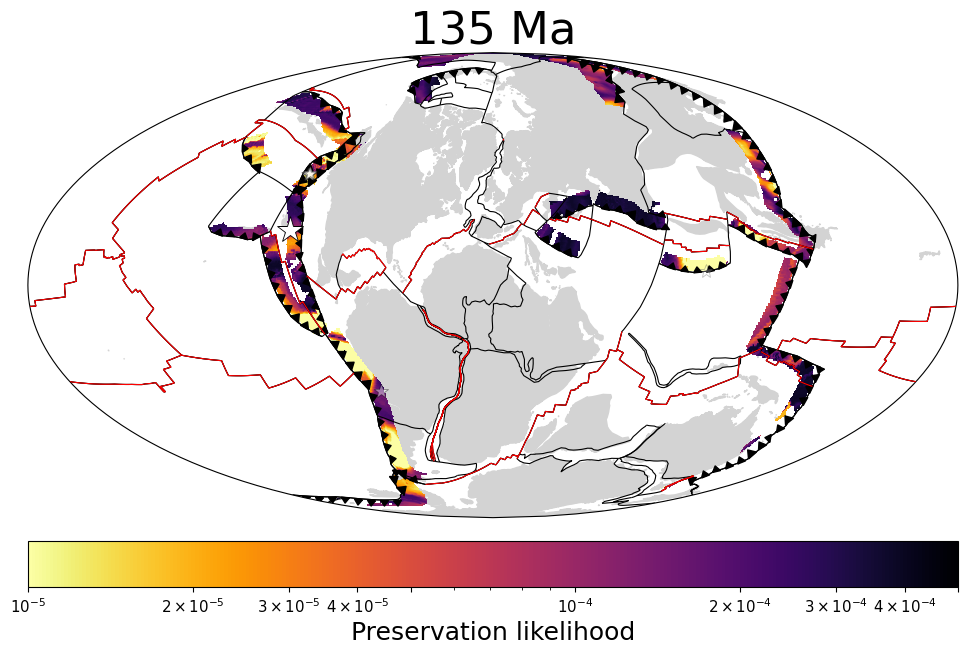

In [10]:
time = 135

_ = plot_likelihood(
    time=time,
    gplot=gplot,
    input_dir=likelihood_dir,
    projection=projection,
    output_filename=None,
    deposits=deposits_filename,
)


#### All plots

In [11]:
with tempfile.TemporaryDirectory() as tmpdir:
    plot_likelihood_maps(
        times=times,
        gplot=gplot,
        input_dir=likelihood_dir,
        output_dir=tmpdir,
        projection=projection,
        n_jobs=n_jobs,
        verbose=10 * int(verbose),
        output_template=filename_template,
        deposits=deposits_filename,
    )
    image_filenames = [
        os.path.join(
            tmpdir,
            filename_template.format(t),
        )
        for t in sorted(times, reverse=True)
    ]
    create_animation(
        image_filenames=image_filenames,
        output_filename=output_filename_likelihood,
        fps=5,
        logger=None,
        threads=n_jobs,
    )

Loading data from file: /Users/chris/Desktop/stellar-data-mining/prepared_data/training_data_global.csv


Reconstructing to 170 Ma


Reconstructing to 160 Ma


Reconstructing to 150 Ma


Reconstructing to 140 Ma


Reconstructing to 130 Ma


Reconstructing to 120 Ma


Reconstructing to 110 Ma


Reconstructing to 100 Ma


Reconstructing to 90 Ma


Reconstructing to 80 Ma


Reconstructing to 70 Ma


Reconstructing to 60 Ma


Reconstructing to 50 Ma


Reconstructing to 40 Ma


Reconstructing to 30 Ma


Reconstructing to 20 Ma


Reconstructing to 10 Ma


Reconstructing to 0 Ma
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  3.8min remaining: 11.4min


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  3.8min remaining:  6.4min


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  3.9min remaining:  3.9min


[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  3.9min remaining:  2.3min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  3.9min remaining:  1.3min


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.9min finished


### Prospectivity $\times$ log(preservation likelihood)

In [14]:
# Transform and scale likelihood
x = np.dstack(
    [
        np.array(
            xr.load_dataset(
                os.path.join(
                    likelihood_dir,
                    f"preservation_likelihood_grid_{t:0.0f}Ma.nc",
                )
            )["z"]
        )
        for t in times
    ]
)
x = x[~np.logical_or(np.isnan(x), x == 0.0)].reshape((-1, 1))

transformer = make_pipeline(
    FunctionTransformer(np.log, np.exp, check_inverse=False),
    MinMaxScaler(),
).fit(x)


#### Example plot

Create an example plot at a single time step (by default, 135 Ma).

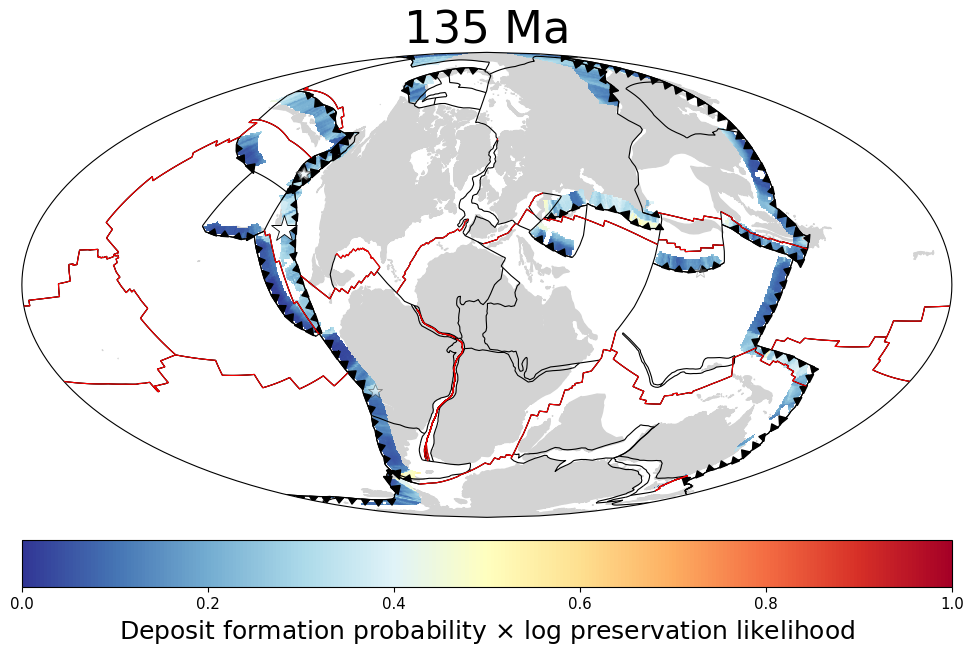

In [15]:
time = 135

_ = plot_combined(
    time=time,
    gplot=gplot,
    prospectivity_dir=prospectivity_dir,
    preservation_dir=likelihood_dir,
    projection=projection,
    output_filename=None,
    deposits=deposits_filename,
    method="likelihood",
    transformer=transformer,
)


#### All plots

In [16]:
with tempfile.TemporaryDirectory() as tmpdir:
    plot_combined_maps(
        times=times,
        gplot=gplot,
        prospectivity_dir=prospectivity_dir,
        preservation_dir=likelihood_dir,
        output_dir=tmpdir,
        projection=projection,
        n_jobs=n_jobs,
        verbose=10 * int(verbose),
        output_template=filename_template,
        deposits=deposits_filename,
        method="likelihood",
        transformer=transformer,
    )
    image_filenames = [
        os.path.join(
            tmpdir,
            filename_template.format(t),
        )
        for t in sorted(times, reverse=True)
    ]
    create_animation(
        image_filenames=image_filenames,
        output_filename=output_filename_combined,
        fps=5,
        logger=None,
        threads=n_jobs,
    )

Loading data from file: /Users/chris/Desktop/stellar-data-mining/prepared_data/training_data_global.csv


Reconstructing to 170 Ma


Reconstructing to 160 Ma


Reconstructing to 150 Ma


Reconstructing to 140 Ma


Reconstructing to 130 Ma


Reconstructing to 120 Ma


Reconstructing to 110 Ma


Reconstructing to 100 Ma


Reconstructing to 90 Ma


Reconstructing to 80 Ma


Reconstructing to 70 Ma


Reconstructing to 60 Ma


Reconstructing to 50 Ma


Reconstructing to 40 Ma


Reconstructing to 30 Ma


Reconstructing to 20 Ma


Reconstructing to 10 Ma


Reconstructing to 0 Ma
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  3.3min remaining:  9.8min


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  3.3min remaining:  5.5min


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  3.3min remaining:  3.3min


[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  3.3min remaining:  2.0min


[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  3.3min remaining:  1.1min


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.4min finished


#### Plot without deposit locations

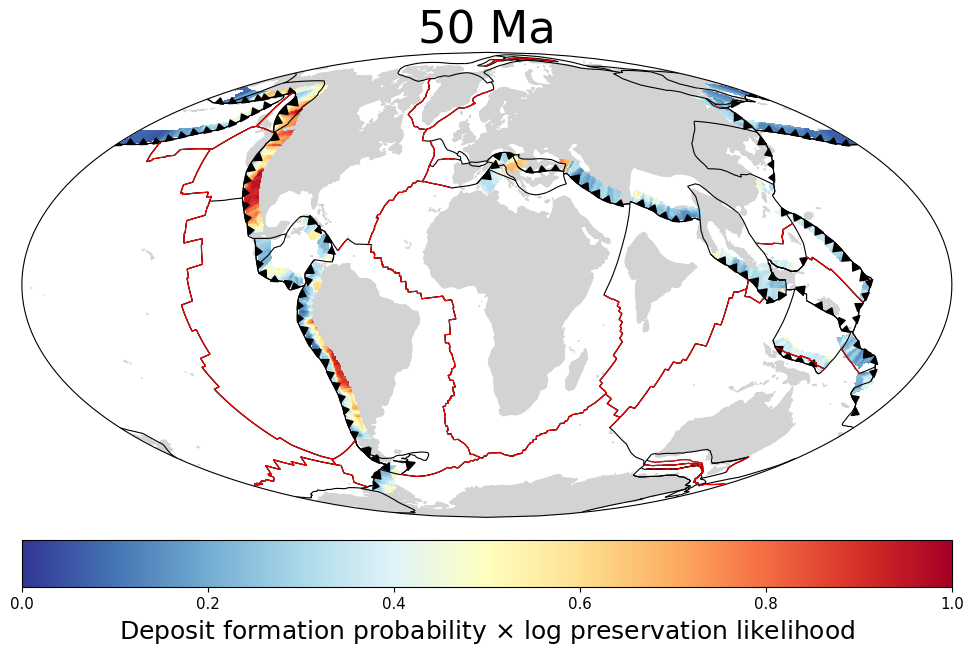

In [17]:
time = 50

_ = plot_combined(
    time=time,
    gplot=gplot,
    prospectivity_dir=prospectivity_dir,
    preservation_dir=likelihood_dir,
    projection=projection,
    output_filename=None,
    deposits=None,
    method="likelihood",
    transformer=transformer,
)


In [18]:
with tempfile.TemporaryDirectory() as tmpdir:
    plot_combined_maps(
        times=times,
        gplot=gplot,
        prospectivity_dir=prospectivity_dir,
        preservation_dir=likelihood_dir,
        output_dir=tmpdir,
        projection=projection,
        n_jobs=n_jobs,
        verbose=10 * int(verbose),
        output_template=filename_template,
        deposits=None,
        method="likelihood",
        transformer=transformer,
    )
    image_filenames = [
        os.path.join(
            tmpdir,
            filename_template.format(t),
        )
        for t in sorted(times, reverse=True)
    ]
    create_animation(
        image_filenames=image_filenames,
        output_filename=output_filename_combined_nodeps,
        fps=5,
        logger=None,
        threads=n_jobs,
    )

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  3.3min remaining:  9.9min


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  3.3min remaining:  5.5min


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  3.3min remaining:  3.3min


[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  3.4min remaining:  2.0min


[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  3.4min remaining:  1.1min


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.4min finished
